## 准备工作，加载相关的模块

In [ ]:
!pip install gradio
!pip install torch
!pip uninstall -y transformers
!pip install git+https://github.com/huggingface/transformers
!pip install diffusers
!pip install accelerate
!pip install tiktoken

In [ ]:
#登录HF
!pip install -U huggingface_hub
!huggingface-cli login

## 生成图片环节

### 对比直出和lora加载后的不同。 直出产品图：

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    print("CUDA is not available. Using CPU instead.")

# 加载模型并指定设备
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)
prompt = "A watch"
image = pipeline(prompt).images[0]
image

'''
# 生成图片
prompt = "A metal cup"
try:
    image = pipeline(prompt).images[0]
except Exception as e:
    print(f"Error generating image: {e}")

#输入图片
image
'''

### 加载lora后的图

In [ ]:
from diffusers import AutoPipelineForText2Image
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    print("CUDA is not available. Using CPU instead.")

# 加载模型并指定设备
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)

# 加载 LoRA 权重
try:
    pipeline.unet.load_attn_procs("TigerHatKth/metal_Lora", weight_name="pytorch_lora_weights.safetensors")
except Exception as e:
    print(f"Error loading LoRA weights: {e}")

# 生成图片
prompt = "A metal cup"
try:
    image = pipeline(prompt).images[0]
except Exception as e:
    print(f"Error generating image: {e}")

#输入图片
image


## 生成描述和后续文字准备工作


### 描述生成的图片

In [4]:
from transformers import pipeline

if torch.cuda.is_available():
    device = 0  # 使用第一个GPU设备
else:
    device = -1  # 表示CPU
    print("CUDA is not available. Using CPU instead.")

# 加载图生文模型并指定设备
pipe = pipeline("image-to-text", model="Salesforce/blip-image-captioning-large", device=device)



try:
    # 生成文字描述
    image_text = pipe(image)[0]['generated_text']
except Exception as e:
    print(f"An error occurred: {e}")





config.json:   0%|          | 0.00/4.60k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/527 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

preprocessor_config.json:   0%|          | 0.00/445 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


'\ncaptioner = pipeline("image-to-text",model="Salesforce/blip-image-captioning-base")\ncaptioner("https://huggingface.co/datasets/Narsil/image_dummy/resolve/main/parrots.png")\n## [{\'generated_text\': \'two birds are standing next to each other \'}]\n'

## 文字扩写部分

### 为简单的描述扩展一个用户画像描述

In [ ]:
from transformers import AutoModelForCausalLM, AutoTokenizer
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

tokenizer = AutoTokenizer.from_pretrained('stabilityai/stablelm-2-zephyr-1_6b', trust_remote_code=True)

model = AutoModelForCausalLM.from_pretrained(
    'stabilityai/stablelm-2-zephyr-1_6b',
    trust_remote_code=True
)
model.to(device)

prompt_text =  "Hi, you are a designer and please help todescribe a person in detail that is using the object in a personaformat: " +image_text
prompt = [{'role': 'user', 'content': prompt_text}]
inputs = tokenizer.apply_chat_template(
    prompt,
    add_generation_prompt=True,
    return_tensors='pt'
)

tokens = model.generate(
    inputs.to(model.device),
    max_new_tokens=1024,
    temperature=0.5,
    do_sample=True
)


persona_text = str(tokenizer.decode(tokens[0], skip_special_tokens=True))
print(persona_text)




### 提取回答的用户画像相关内容

In [ ]:
text = persona_text
# 查找 "Persona:" 子字符串的位置
start_index = text.find("Persona:")

# 检查是否找到了 "Persona:"
if start_index != -1:
    # 提取 "Persona:" 之后的内容
    persona_info = text[start_index:]
    print(persona_info)
else:
    print("Persona section not found in the text.")

### 废话太多，我们来精简一下作为sd的提示词

In [ ]:
from transformers import pipeline

summarizer = pipeline("summarization", model="Falconsai/text_summarization")

ARTICLE = persona_info


sd_prompt = summarizer(ARTICLE, max_length=200, min_length=100, do_sample=False)
sd_prompt= str(sd_prompt[0]['summary_text'])

print(sd_prompt)


In [10]:
sd_prompt= sd_prompt[0]['summary_text']

### 生成一个用户画像

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Token indices sequence length is longer than the specified maximum sequence length for this model (88 > 77). Running this sequence through the model will result in indexing errors
The following part of your input was truncated because CLIP can only handle sequences up to 77 tokens: ['the close proximity to restaurants, cafes, and shops.']


  0%|          | 0/50 [00:00<?, ?it/s]

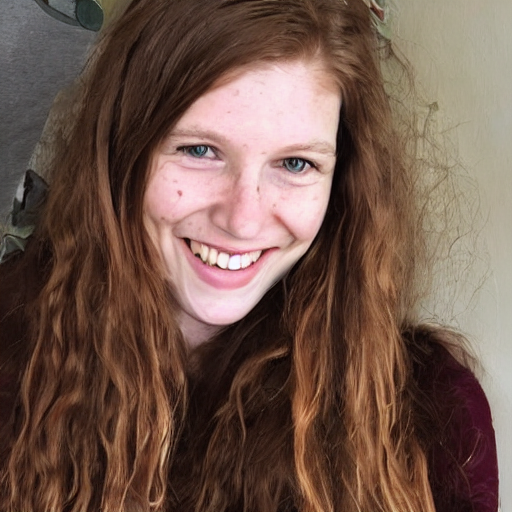

In [13]:
from diffusers import AutoPipelineForText2Image
import torch

# 检查CUDA是否可用
if torch.cuda.is_available():
    device = "cuda"
else:
    device = "cpu"
    print("CUDA is not available. Using CPU instead.")

# 加载模型并指定设备
pipeline = AutoPipelineForText2Image.from_pretrained("runwayml/stable-diffusion-v1-5", torch_dtype=torch.float16).to(device)
prompt = sd_prompt
image = pipeline(prompt).images[0]
image